# Topic Modelling Visualization Design Based on IMDA Dataset - Part 6: Call Center Design 2

## Overview

This notebook focuses on creating insightful visualizations and diagrams based on the sentiment-labeled results derived from the IMDA Call Center dataset.  
The aim is to provide a deeper understanding of the key patterns and trends in customer-agent interactions by analyzing sentiment distribution, topic breakdowns, and temporal changes.    
These visualizations can assist in identifying areas for improvement in call center operations and enhance customer satisfaction.

---

## Objectives

1. **Topic-Based Sentiment Analysis:**  
   Visualize the sentiment breakdown across different topics (e.g., banking, insurance, telecom) to understand how customers feel about various services.

2. **Temporal Analysis:**  
   - Examine the volume of calls distributed across weekdays, with a focus on identifying peaks in call activity (e.g., Fridays and Saturdays).
   - Investigate whether sentiment improves or deteriorates as calls progress, providing insights into issue resolution effectiveness.

3. **Call Trends and Sentiment Dynamics:**  
   Track sentiment shifts during calls to explore if agents successfully resolve customer concerns over time.

---

## Key Visualizations

1. **Topic Sentiment Breakdown:**  
   A stacked bar chart displaying the proportion of positive, negative, and neutral sentiments for each topic.

2. **Call Volume by Weekday:**  
   A bar chart showing the distribution of call numbers across weekdays, highlighting the busiest days.

3. **Sentiment Dynamics Over Time:**  
   A line chart showcasing sentiment scores over the course of calls, revealing trends in customer satisfaction during interactions.

4. **Aggregated Statistics:**  
   Summary statistics and distributions of sentiment scores for each topic and time period.

---

## Dataset and Workflow

1. **Setup & Load Data:**  
   - **Pre-generated Sentiment Results:** Includes `final_sentiment_score`, `final_sentiment_label`, and associated metadata like `session_id`, `dialog_type`, and `time`.

2. **Processing Steps:**  
   - Text processing - tokenization
   - Build Document Matrix & LDA Topic Model: clustering session and make the grouping explainable
   - Post-processing
   - Group data by relevant attributes (e.g., `dialog_type`, `session_id`, `weekday`) to compute statistics.
   - Generate visualizations that effectively communicate key findings.

---

## Outcomes

- Clear insights into customer sentiments across various topics and timeframes.
- Identification of high-impact areas for improving customer-agent interactions.
- A foundation for further analysis or reporting based on call center sentiment data.

# Setup

In [ ]:
!pip install pyLDAvis

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from google.colab import drive
drive.mount('/content/drive')


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
snowball = nltk.SnowballStemmer('english')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# load data


In [ ]:
data_df = pd.read_csv('/content/drive/MyDrive/PLP/input/IMDA_original1_RAW_180K.csv')
data_df['speaker_id'] =  data_df['speaker_id'].astype(int)
data_df['session_id'] =  data_df['session_id'].astype(int)
print("total shape:", data_df.shape)
data_df = data_df[data_df.speaker_type=='client']

total shape: (185185, 12)


In [ ]:
data_df_senti = pd.read_csv('/content/drive/MyDrive/PLP/text_model_ZY/IMDA_session2_merged_rule_n_GPT4o.csv')
data_df_senti = data_df_senti[data_df_senti.speaker_type=='client']
data_df_senti['speaker_id'] =  data_df_senti['speaker_id'].astype(int)
data_df_senti['session_id'] =  data_df_senti['session_id'].astype(int)
print("qualified client with sentiment shape :", data_df_senti.shape)
data_df_senti['cleaned_text_for_sentiment'] = data_df_senti['cleaned_text_for_sentiment'].fillna('').astype(str)
data_df_senti['score_bin'] = pd.cut(data_df_senti['final_sentiment_score'], bins=[i/10 for i in range(-10, 11)], include_lowest=True)
def categorize_sentiment(score):
    if score > 0.25:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'
stats = data_df_senti.groupby(by=['dialog_type','session_id'])['final_sentiment_score'].mean().reset_index()
stats['session_sentiment'] = stats['final_sentiment_score'].apply(categorize_sentiment)
stats = stats.dropna()

def check_sentiment_improvement(group):
    halfway_point = len(group) // 2
    start_scores = group['final_sentiment_score'].iloc[:halfway_point]
    end_scores = group['final_sentiment_score'].iloc[halfway_point:]
    start_avg = np.mean(start_scores)
    end_avg = np.mean(end_scores)
    sentiment_improved = end_avg > start_avg
    return pd.Series({
        'start_avg': start_avg,
        'end_avg': end_avg,
        'sentiment_improved': sentiment_improved
    })
# Group by session_id and dialog_type, then apply the function
result = data_df_senti.groupby(by=['dialog_type','session_id']).apply(check_sentiment_improvement)
result.dropna().reset_index()
stats = pd.concat([stats,result.dropna().reset_index()['sentiment_improved']],join="inner", axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


qualified client with sentiment shape : (38339, 27)


<ipython-input-42-e4a61c998571>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = data_df_senti.groupby(by=['dialog_type','session_id']).apply(check_sentiment_improvement)


In [ ]:
# Group by 'session_id', 'dialog_type', and 'speaker_type', and concatenate 'cleaned_text_for_sentiment'
session_df = data_df.groupby(by=["session_id", "dialog_type", "speaker_type"]).agg({
    'cleaned_text_for_sentiment':lambda x: ' '.join(x.astype(str))  # Join the text with a space between sentences
}).reset_index()
session_df.columns = ['session_id', 'dialog_type', 'speaker_type', 'content']
text = session_df[['content']]
text.shape

(1978, 1)

In [ ]:
# # Step 1: Create a group_id by splitting all rows within each group into 3 equal-sized groups
# data_df['group_id'] = data_df.groupby(['session_id', 'dialog_type', 'speaker_type']).cumcount() #//5

# # Step 2: Use pd.qcut to split the rows into 3 groups within each group
# data_df['group_id'] = data_df.groupby(['session_id', 'dialog_type', 'speaker_type'])['group_id'].transform(
#     lambda x: pd.qcut(x + 1, 3, labels=[0, 1, 2])  # Split into 3 groups: 0, 1, 2
# )

# # Step 2: Concatenate the 'content' column for every group of 5 rows within the same group
# merged_sent_df = data_df.groupby(['session_id', 'dialog_type', 'speaker_type', 'group_id']).agg({
#     'cleaned_text_for_sentiment': ' '.join  # Join the content within the group
# }).reset_index()
# merged_sent_df.columns = ['session_id', 'dialog_type', 'speaker_type',  'group_id', 'content']
# # Step 3: Filter for only 'client' speaker_type
# text = merged_sent_df[merged_sent_df.speaker_type == 'client'][['content']]
# text  = text.dropna()
# # View the result
print(text)

                                                content
0     hi my name is john (uh) I'm calling in with in...
1     hi morning my name is john I'm calling in to (...
2     we have this plan of a I think it's a one mega...
3     hi (err) yes I am thinking of enquiring a cred...
4     [ah] yes I would like to make a claim please i...
...                                                 ...
1970  hi I'm actually <P2>florence</P2> I'm actually...
1971  hi lily this is <P2>florence</P2> I'm actually...
1972  (uh) yes I have a savings account with the ban...
1973  okay sure (uh) can you call me (ppb) miss tan ...
1974  hi (uh) good afternoon lily (ppb) (uh) I'm cal...

[1975 rows x 1 columns]


# text processing - tokenize

In [ ]:
def text_preprocessing(tt):
    filter_list = [ "’", "“", "”", "'t", "'s", "would", "could","ya","er","mm","mmhmm","um","uh",
                   "ppo","ye","see","i","calling","lah","ha","yeah",
                   "hi","hello","okay","yes","err","ah","oh","hi","right","ppb","b","'ll","'m","yup","sure",
                    "see","say","let","also","n't","think", "one", "two", "three","call",
                    'know', 'actually', 'get','four','five', 'hundred','need', 'go','thank', 'maybe', 'good', 'mean',
                    'well', 'six','seven','eight','nine','ten', 'bye', 'quite','really','day','looking']
    #fileter list redefined after top terms review, 50 cases keywords reviewed, cluster condition changed after keywords filtered
    toks = nltk.word_tokenize(tt.lower())
    toks = [ t for t in toks if t not in string.punctuation + "’“”" ]
    toks = [ t for t in toks if not t.isnumeric() ]
    toks = [ lemmatizer.lemmatize(t) for t in toks if t not in stop_words ]
    toks = [t for t in toks if t not in filter_list and "~" not in t and "'" not in t and len(t)>=3]
    #toks = [snowball.stem(t) for t in toks
    return ' '.join(toks)

# Preprocess each report
preprocessed_reports = [text_preprocessing(text) for text in text['content']]
# Convert to DataFrame
df = pd.DataFrame(preprocessed_reports, columns=['tokens'], index=text.index)

df.head()

,tokens
0,name john regard enquiring home loan bank give...
1,morning morning name john enquire car insuranc...
2,morning telco john regard broadband plan house...
3,thinking enquiring credit card suit like going...
4,like make claim please travel insurance huh mo...


In [ ]:
def text_to_tokens(text):
    tokens = nltk.word_tokenize(text)
    return tokens
tokens = df['tokens'].apply(text_to_tokens)


all_tokens = []
df['tokens'].apply(lambda text: all_tokens.extend(nltk.word_tokenize(text)))
frequency_token = nltk.FreqDist(all_tokens)
top_50_words_list = frequency_token.most_common(50)
print("Top-50 most frequent words:", top_50_words_list)

Top-50 most frequent words: [('like', 20912), ('plan', 7484), ('card', 7371), ('credit', 4438), ('much', 4251), ('insurance', 4251), ('phone', 4124), ('dollar', 3615), ('month', 3529), ('time', 3477), ('want', 3312), ('year', 2957), ('travel', 2808), ('twenty', 2395), ('use', 2183), ('data', 2183), ('number', 2171), ('alright', 2141), ('cashback', 2109), ('check', 2069), ('claim', 2034), ('pay', 2033), ('thousand', 1986), ('back', 1901), ('correct', 1839), ('thing', 1837), ('apply', 1755), ('car', 1728), ('understand', 1626), ('online', 1597), ('mobile', 1594), ('lot', 1584), ('still', 1577), ('name', 1541), ('take', 1503), ('new', 1500), ('reward', 1499), ('currently', 1476), ('per', 1465), ('something', 1418), ('first', 1407), ('telco', 1397), ('company', 1392), ('make', 1382), ('iphone', 1381), ('kind', 1363), ('able', 1362), ('fee', 1349), ('spend', 1326), ('bank', 1317)]


In [ ]:
# Vectorize the text data
# vectorizer = TfidfVectorizer(max_df=0.8, max_features=500,
#                              min_df=53, use_idf=True)
# X = vectorizer.fit_transform(df['tokens'])
# X.shape

(1975, 500)

# Build Document Matrix & LDA Topic model

In [ ]:
import gensim
from gensim import corpora



# Filter off any words with document frequency less than 10, or appearing in more than 80% documents
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=10, no_above=0.75)
"""
        no_below : int, optional
            Keep tokens which are contained in at least `no_below` documents.
        no_above : float, optional
            Keep tokens which are contained in no more than `no_above` documents
            (fraction of total corpus size, not an absolute number).
"""
doc_term_matrix = [dictionary.doc2bow(text) for text in tokens]
lda_model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics = 8,
                                      id2word = dictionary,
                                      chunksize=256,
                                      passes=20,
                                      random_state=42)
lda_model.show_topics(8)

topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.045*"travel" + 0.042*"insurance" + 0.028*"plan" + 0.017*"cover" + 0.015*"trip" + 0.012*"family" + 0.012*"going" + 0.011*"want" + 0.011*"tier" + 0.010*"coverage"')
(1, '0.078*"card" + 0.046*"credit" + 0.023*"cashback" + 0.016*"reward" + 0.014*"spend" + 0.012*"mile" + 0.012*"month" + 0.011*"apply" + 0.011*"fee" + 0.011*"air"')
(2, '0.034*"insurance" + 0.033*"car" + 0.018*"year" + 0.015*"accident" + 0.014*"plan" + 0.012*"personal" + 0.011*"thousand" + 0.009*"time" + 0.008*"premium" + 0.008*"pay"')
(3, '0.048*"account" + 0.042*"loan" + 0.027*"saving" + 0.027*"bank" + 0.026*"interest" + 0.025*"thousand" + 0.022*"month" + 0.020*"rate" + 0.019*"year" + 0.013*"take"')
(4, '0.025*"broadband" + 0.021*"room" + 0.020*"wi-fi" + 0.018*"home" + 0.017*"house" + 0.014*"mesh" + 0.012*"work" + 0.011*"service" + 0.009*"use" + 0.009*"internet"')
(5, '0.038*"plan" + 0.018*"month" + 0.018*"want" + 0.012*"time" + 0.011*"orh" + 0.011*"use" + 0.011*"phone" + 0.011*"telco" + 0.010*"new" + 0.010*"data"')
(

## identify the meaning of clusters from the results

In [ ]:
import pyLDAvis.gensim
import pickle
import pyLDAvis

# pyLDAvis.enable_notebook()
# LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
topic_labels = {
    0: "Travel Insurance Plan",
    1: "Banking Credit Card Application",
    2: "Insurance Car", # "inquiry",
    3: "Banking Loan",  #"Banking Account Interest Rate", #"Telecom Home broadband",
    4: "Telecom Broadband Plan", # "Telecom Mobile Data Plan",#
    5: "Telecom",  #"Banking Credit Card Inquiry", "Insurance Plan",
    6: "Telecom Mobile Plan",
    7: "Insurance Claim"
    # Add more topics as needed based on your analysis
}


pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model,doc_term_matrix, dictionary)
pyLDAvis.save_html(LDAvis_prepared, 'lda_vis_with_topics.html')
pyLDAvis.display(LDAvis_prepared)
# Optionally, you can display it directly if you're working in a notebook environment
# pyLDAvis.display(Llda_model)

In [ ]:
# Assuming `tokens` is your DataFrame column that holds tokenized documents
# `doc_term_matrix` is already created from the tokens using `dictionary.doc2bow`
topic_labels = {
    0: "Travel Insurance Plan",
    1: "Credit Card Application",
    2: "Insurance Car",
    3: "Banking Loan",
    4: "Telecom Broadband Plan",
    5: "Telecom Inquiry",   # "inquiry",
    6: "Telecom Mobile Plan",
    7: "Insurance Claim"
}
# Get the most probable topic for each document in your dataset
def get_dominant_topic(doc_term_matrix, lda_model):
    topic_distribution = lda_model.get_document_topics(doc_term_matrix)
    # Get the topic with the highest probability
    dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]  # x[0] is the topic, x[1] is the probability
    return dominant_topic

# Apply the function to all documents in your token dataframe
# Add a new column 'assigned_topic' to your DataFrame to store the assigned cluster for each document
# assigned_topic = [get_dominant_topic(doc, lda_model) for doc in doc_term_matrix]
session_df['cluster'] = pd.Series(tokens['assigned_topic'],name="cluster_id")
session_df['assigned_topic'] = session_df['cluster'].apply(lambda x: topic_labels[x])

session_df.groupby('assigned_topic')[['dialog_type']].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


assigned_topic           dialog_type
Banking Loan             bank            85
Credit Card Application  bank           544
Insurance Car            insurance      152
                         bank            26
Insurance Claim          insurance      245
                         bank             4
                         telecom          1
Telecom Broadband Plan   telecom         84
Telecom Inquiry          telecom        146
                         bank             2
Telecom Mobile Plan      telecom        430
Travel Insurance Plan    insurance      259
Name: count, dtype: int64

# Data Post-processing for Visualization 

### to mimic a distribution porporion of the topics for visualization

In [ ]:
import random

# Generate random numbers for case numbers of topics
# telecom_cases = random.randint(45, 55)  # Random number around 50 for telecom
# insurance_cases = random.randint(300, 500)  # Random number between 300 and 500 for insurance
# bank_cases = random.randint(300, 500)  # Random number between 300 and 500 for bank
# telecom_cases,insurance_cases,bank_cases  (54, 315, 403)

sample_sizes = {
    'insurance': 315,  # Random number between 300 and 500
    'bank': 403,  # Random number between 300 and 500
    'telecom': 54  # Fixed number of 50
}

# Randomly sample from session_df based on dialog_type
sampled_sessions = pd.concat([
    session_df[session_df['dialog_type'] == dtype].sample(n=sample_sizes[dtype], random_state=42, replace=False)
    for dtype in sample_sizes
]).reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plots

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 400x400 with 0 Axes>

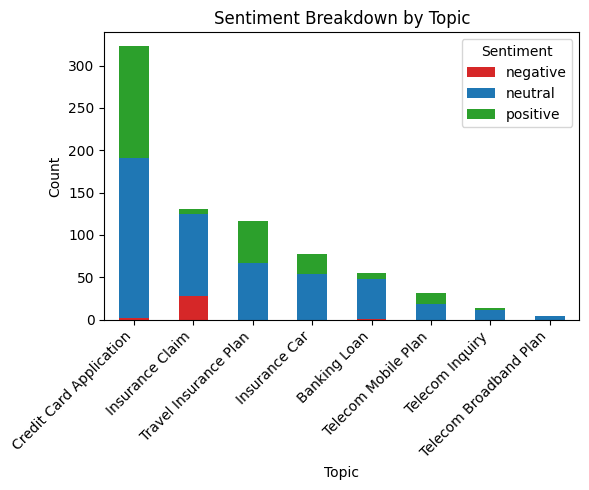

In [ ]:
filtered_sentiment_stats = stats.merge(sampled_sessions[['dialog_type','session_id','assigned_topic']], on=['dialog_type', 'session_id'], how='inner')
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
sentiment_by_topic = filtered_sentiment_stats.groupby(['assigned_topic', 'session_sentiment']).size().unstack(fill_value=0)
sorted_sentiment_by_topic = sentiment_by_topic.sum(axis=1).sort_values(ascending=False)
sentiment_by_topic_sorted = sentiment_by_topic.loc[sorted_sentiment_by_topic.index]
sentiment_by_topic_sorted.plot(kind='bar', stacked=True, figsize=(6, 5), color=['#d62728', '#1f77b4', '#2ca02c'])

# Add labels and title

plt.title('Sentiment Breakdown by Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


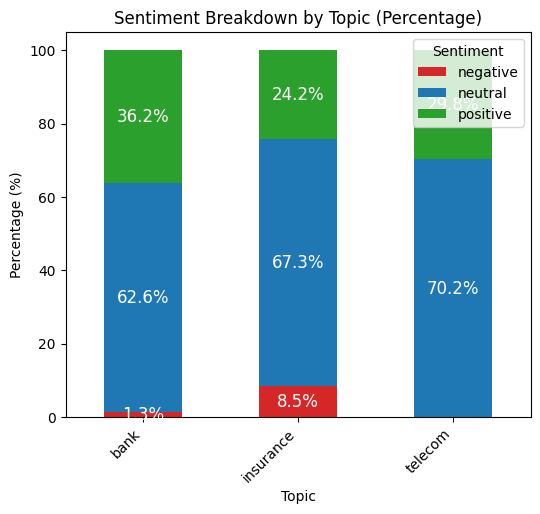

In [ ]:
# Calculate percentage instead of counts
sentiment_by_topic = filtered_sentiment_stats.groupby(['dialog_type', 'session_sentiment']).size().unstack(fill_value=0)
sentiment_by_topic_percentage = sentiment_by_topic.div(sentiment_by_topic.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with percentages
ax = sentiment_by_topic_percentage.plot(kind='bar', stacked=True, figsize=(6,5), color=['#d62728', '#1f77b4', '#2ca02c'])

# Add labels and title
plt.title('Sentiment Breakdown by Topic (Percentage)')
plt.xlabel('Topic')
plt.ylabel('Percentage (%)')
plt.legend(title='Sentiment')
plt.xticks(rotation=45, ha="right")

# Annotate percentage for 'negative' and 'positive' slots
for i, p in enumerate(ax.patches):
    # Get the row and column index for the current patch
    row = i // len(sentiment_by_topic_percentage.columns)  # Row index based on total columns
    col = i % len(sentiment_by_topic_percentage.columns)  # Column index (which sentiment)

    # Only annotate negative (first bar) and positive (last bar)
    sentiment_category = sentiment_by_topic_percentage.columns[col]
    # if sentiment_category in ['negative', 'positive']:  # Filter only Negative and Positive
    width = p.get_width()
    height = p.get_height()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    if height > 0:  # Only show labels for non-zero bars
        ax.text(x, y, f'{height:.1f}%', ha='center', va='center', fontsize=12, color='white')


# plt.tight_layout()
plt.show()

### to mimic a week day breakdown to demo the statistics summary visualization

In [ ]:
# Define the weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Define the probabilities, with higher values for Friday and Saturday
probabilities = [0.1, 0.1, 0.1, 0.1, 0.25, 0.25, 0.1]

# Randomly assign weekdays to the filtered_sentiment_stats DataFrame
filtered_sentiment_stats['weekday'] = np.random.choice(weekdays, size=len(filtered_sentiment_stats), p=probabilities)

# Check the distribution of assigned weekdays
print(filtered_sentiment_stats['weekday'].value_counts())

weekday
Friday       210
Saturday     186
Tuesday       78
Sunday        74
Thursday      70
Wednesday     67
Monday        66
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 400x400 with 0 Axes>

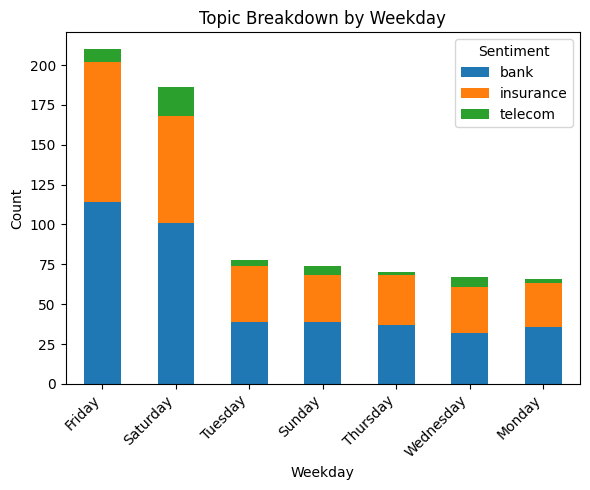

In [ ]:
plt.figure(figsize=(4,4))
sentiment_by_topic = filtered_sentiment_stats.groupby(['weekday', 'dialog_type']).size().unstack(fill_value=0)
sorted_sentiment_by_topic = sentiment_by_topic.sum(axis=1).sort_values(ascending=False)
sentiment_by_topic_sorted = sentiment_by_topic.loc[sorted_sentiment_by_topic.index]
sentiment_by_topic_sorted.plot(kind='bar', stacked=True, figsize=(6, 5))

# Add labels and title

plt.title('Topic Breakdown by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()

### plots2 sub topic

In [ ]:
filtered_sentiment_stats = stats.merge(sampled_sessions[['dialog_type','session_id','assigned_topic']], on=['dialog_type', 'session_id'], how='inner')
filtered_sentiment_stats

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,dialog_type,session_id,final_sentiment_score,session_sentiment,sentiment_improved,assigned_topic
0,bank,683,0.061857,neutral,True,Banking Loan
1,bank,685,0.220335,neutral,False,Banking Credit Card Application
2,bank,686,0.085184,neutral,False,Banking Credit Card Application
3,bank,689,0.090160,neutral,False,Banking Credit Card Application
4,bank,690,-0.132614,negative,True,Insurance Claim
...,...,...,...,...,...,...
746,telecom,1201,0.204095,neutral,False,Telecom Mobile Plan
747,telecom,1235,0.190179,neutral,False,Telecom Mobile Plan
748,telecom,1236,0.263475,positive,True,Telecom
749,telecom,1237,0.064621,neutral,True,Telecom Mobile Plan


# THE END
# Appendix

## Kmeans clustering

Top terms for cluster 0 (bank account inquiry): month, loan, rate, deposit, bank, credit, interest, card, saving, account

Top terms for cluster 1 (telecom mobile plan): dollar, gig, student, g_b, mobile, twelve, data, iphone, phone, plan

Top terms for cluster 2 (bank credit card): mile, spending, bank, fee, month, reward, spend, cashback, credit, card

Top terms for cluster 3 (telecom home wifi): house, telco, home, wifi, plan, fi, wi, room, mesh, broadband

Top terms for cluster 4 (insurance travel inquiry): claim, premium, tier, trip, coverage, accident, cover, plan, travel, insurance

Top terms for cluster 5 (bank credit card -1): fee, point, apply, spend, air, mile, reward, cashback, credit, card

Top terms for cluster 6 (insurance claim): delay, hospital, lost, went, back, baggage, luggage, insurance, flight, claim

Top terms for cluster 7 (telecom data plan-1): contract, want, twenty, dollar, gig, telco, mobile, data, plan, phone

Top terms for cluster 8 (bank loan): income, c_p_f, bank, h_d_b, interest, rate, year, thousand, car, loan

Top terms for cluster 9 (insurance car insurance): cover, drive, driver, year, driving, accident, claim, workshop, insurance, car

## sample archive gensim (from topic modelling notebook )

In [ ]:
# Filter off any words with document frequency less than 2, or appearing in more than 90% documents
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=10, no_above=0.8)
"""
        no_below : int, optional
            Keep tokens which are contained in at least `no_below` documents.
        no_above : float, optional
            Keep tokens which are contained in no more than `no_above` documents
            (fraction of total corpus size, not an absolute number).
"""
#dtm here is a list of lists, which is exactly a matrix
dtm = [dictionary.doc2bow(d) for d in tokens]
lda = gensim.models.ldamodel.LdaModel(dtm, num_topics = 8,
                                      id2word = dictionary,
                                      chunksize=256,
                                      passes=20,
                                      random_state=13)
lda.show_topics(10)

[(0,
  '0.031*"claim" + 0.022*"back" + 0.021*"flight" + 0.017*"insurance" + 0.016*"baggage" + 0.014*"luggage" + 0.013*"lost" + 0.012*"went" + 0.011*"travel" + 0.010*"singapore"'),
 (1,
  '0.052*"plan" + 0.041*"phone" + 0.023*"data" + 0.017*"dollar" + 0.014*"mobile" + 0.014*"time" + 0.014*"month" + 0.014*"iphone" + 0.013*"twenty" + 0.012*"want"'),
 (2,
  '0.021*"thing" + 0.016*"time" + 0.013*"something" + 0.012*"ppl" + 0.012*"company" + 0.012*"help" + 0.011*"sound" + 0.011*"make" + 0.010*"want" + 0.010*"bit"'),
 (3,
  '0.036*"account" + 0.032*"loan" + 0.030*"thousand" + 0.025*"year" + 0.021*"month" + 0.020*"saving" + 0.020*"interest" + 0.020*"bank" + 0.016*"rate" + 0.014*"pay"'),
 (4,
  '0.085*"card" + 0.050*"credit" + 0.025*"cashback" + 0.018*"reward" + 0.015*"spend" + 0.013*"mile" + 0.013*"month" + 0.012*"fee" + 0.012*"apply" + 0.012*"air"'),
 (5,
  '0.080*"car" + 0.042*"insurance" + 0.019*"claim" + 0.015*"accident" + 0.010*"drive" + 0.010*"workshop" + 0.010*"year" + 0.009*"driving" +

In [ ]:
##Evaluate the coherence score of LDA models
'''
u_mass:prefer the model close to 0
c_v: [0,1], prefer bigger value
Do not fully rely on the coherence score
'''
from gensim.models.coherencemodel import CoherenceModel
cm_umass = CoherenceModel(lda,  dictionary=dictionary, corpus=dtm, coherence='u_mass')
cm_cv = CoherenceModel(lda,  dictionary=dictionary, texts=tokens, coherence='c_v')
lda_umass = cm_umass.get_coherence()
lda_cv = cm_cv.get_coherence()
print(lda_umass)
print(lda_cv)

-0.9659582080482607
0.5463953251416387


In [ ]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, dtm, dictionary)
pyLDAvis.display(LDAvis_prepared)